In [1]:
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import pandas as pd
from sklearn import model_selection
from sklearn import preprocessing
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from time import time
from scipy.stats import randint as sp_randint
import numpy as np

In [2]:
#warmstart only useful when you want to add more estimators!
#regr = RandomForestRegressor(n_jobs=-1, random_state=0,n_estimators=100,max_features = 5, warm_start = True)#,oob_score=True, verbose = 1) # verbose only prints time and parallel jobs..oob score doesnt help the fit accuracy
regr = RandomForestRegressor(n_jobs=-1, random_state=0,n_estimators=500, warm_start = True, oob_score=True)
lr = LinearRegression(fit_intercept = False)

In [3]:
scores = pd.read_csv('soretdScores.csv', lineterminator='\n')

In [4]:
data = pd.read_csv('motionData.csv', lineterminator='\n')
data.rename(columns={"FFPType\r": "FFPType"},inplace=True)

In [5]:
FEATURES = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"]
FEATURESALL = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType"]

In [6]:
EMOSCORES = ["happier_mu", "sadder_mu", "angrier_mu"]
EMOCONFIDENCE_INV = ["happier_sigma", "sadder_sigma", "angrier_sigma"]
min_confidence = 25/3 # true skill base confidence: http://trueskill.org/
EMOWTS = ["happier_wt", "sadder_wt", "angrier_wt"]

In [7]:
emotionid = 0;

In [8]:
mapper = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], preprocessing.OneHotEncoder())], input_df = True, sparse = True)

In [9]:
transformedData = mapper.fit_transform(data.copy())

In [10]:
WTS= {'happier_wt':(1.5-(scores[EMOCONFIDENCE_INV[0]]/min_confidence)).values,
                   'sadder_wt':(1.5-(scores[EMOCONFIDENCE_INV[1]]/min_confidence)).values,
                'angrier_wt':(1.5-(scores[EMOCONFIDENCE_INV[2]]/min_confidence)).values}
WTS_df = pd.DataFrame(WTS,scores.index)
scores_WTS = pd.concat([scores, WTS_df], axis = 1)

In [11]:
 X_train, X_test, y_train, y_test = model_selection.train_test_split(transformedData, scores_WTS, test_size=0.2, random_state=42)

In [12]:
svr_rbf = SVR(kernel='rbf')

stregr = StackingRegressor(regressors=[lr, regr], 
                           meta_regressor=svr_rbf)

In [13]:
stregr.get_params()

{'linearregression': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False),
 'linearregression__copy_X': True,
 'linearregression__fit_intercept': False,
 'linearregression__n_jobs': 1,
 'linearregression__normalize': False,
 'meta-svr': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 'meta-svr__C': 1.0,
 'meta-svr__cache_size': 200,
 'meta-svr__coef0': 0.0,
 'meta-svr__degree': 3,
 'meta-svr__epsilon': 0.1,
 'meta-svr__gamma': 'auto',
 'meta-svr__kernel': 'rbf',
 'meta-svr__max_iter': -1,
 'meta-svr__shrinking': True,
 'meta-svr__tol': 0.001,
 'meta-svr__verbose': False,
 'meta_regressor': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 'randomforestregressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto',

In [14]:
# Training the stacking classifier
stregr.fit(X_train, y_train[EMOSCORES[emotionid]])

ytestStack_pred = stregr.predict(X_test)
ytrainStack_pred=stregr.predict(X_train)

In [15]:
print("Mean squared error wtd STACKED DEFAULT(test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytestStack_pred,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd STACKED DEFAULT (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytestStack_pred,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error wtd STACKED DEFAULT(test): 30.81
Variance score wtd STACKED DEFAULT (test): -0.0370


In [16]:
print("Mean squared error wtd  STACKED DEFAULT (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrainStack_pred,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd  STACKED DEFAULT (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrainStack_pred,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd  STACKED DEFAULT (train): 2.67
Variance score wtd  STACKED DEFAULT (train): 0.91


In [17]:
# # specify parameters and distributions to sample from
# param_dist = {"randomforestregressor__max_depth": [3,5,10, 15, 20, 25, 30, None],
#               "randomforestregressor__max_features": sp_randint(3, 15),
#               #"min_samples_split": sp_randint(3, 11),
#               "randomforestregressor__min_samples_leaf": sp_randint(1, 11),
#               "randomforestregressor__criterion": ["mse", "mae"],
#               "meta-svr__C": np.random.uniform(0.1,100.0,1),
#               "meta-svr__gamma": np.random.uniform(0.1,10.0,1)}

# # run randomized search
# n_iter_search = 100
# random_search = RandomizedSearchCV(stregr, param_distributions=param_dist,
#                                    n_iter=n_iter_search, n_jobs=-1, cv =10, random_state = 0)

# start = time()
# random_search.fit(X_train, y_train[EMOSCORES[emotionid]])
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time() - start), n_iter_search))
# print(random_search.cv_results_)

In [18]:
# random_search.best_estimator_ 

In [19]:
#random_search.best_estimator_.meta_regr_

In [20]:
# random_search.best_score_

In [21]:
# ytest_pred_Randcv=random_search.best_estimator_.predict(X_test)
# ytrain_pred_Randcv=random_search.best_estimator_.predict(X_train)

In [22]:
# random_search.best_params_

In [23]:
# print("Mean squared error wtd random cv (test): %.2f"
#       % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred_Randcv,sample_weight=y_test[EMOWTS[emotionid]]))
# # Explained variance score: 1 is perfect prediction
# print('Variance score wtd random cv (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred_Randcv,sample_weight=y_test[EMOWTS[emotionid]]))

In [24]:
# print("Mean squared error wtd (train): %.2f"
#       % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred_Randcv,sample_weight=y_train[EMOWTS[emotionid]]))
# # Explained variance score: 1 is perfect prediction
# print('Variance score wtd (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred_Randcv,sample_weight=y_train[EMOWTS[emotionid]]))

In [25]:
# use a full grid over all parameters
param_grid = {"randomforestregressor__max_depth": [3,5,10, 15, 20, 25, 30, None],
              "randomforestregressor__max_features": ["auto", "sqrt", "log2", None],
              #"min_samples_split": sp_randint(3, 11),
              "randomforestregressor__min_samples_leaf": [ 1,2,5, 10],
              "randomforestregressor__criterion": ["mse", "mae"],
              "meta-svr__C": [0.1, 1.0, 10.0, 100.0],
              "meta-svr__gamma": [0.1, 1.0, 10.0]}

# run grid search
grid_search = GridSearchCV(stregr, param_grid=param_grid, cv=10, n_jobs = -1)
start = time()
grid_search.fit(X_train, y_train[EMOSCORES[emotionid]])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
print(grid_search.cv_results_)

GridSearchCV took 17315.72 seconds for 3072 candidate parameter settings.
{'mean_fit_time': array([  2.33922217,   2.29971695,   2.46275072, ...,  10.1535579 ,
         6.99816468,   4.95227458]), 'std_fit_time': array([ 0.36353482,  0.21303745,  0.13386308, ...,  0.84619436,
        0.80130181,  1.29041809]), 'mean_score_time': array([ 0.35444288,  0.3522871 ,  0.4227746 , ...,  0.87908835,
        0.89372725,  0.19441247]), 'std_score_time': array([ 0.1609444 ,  0.122709  ,  0.08403954, ...,  0.70758584,
        0.66729052,  0.09251583]), 'param_meta-svr__C': masked_array(data = [0.1 0.1 0.1 ..., 100.0 100.0 100.0],
             mask = [False False False ..., False False False],
       fill_value = ?)
, 'param_meta-svr__gamma': masked_array(data = [0.1 0.1 0.1 ..., 10.0 10.0 10.0],
             mask = [False False False ..., False False False],
       fill_value = ?)
, 'param_randomforestregressor__criterion': masked_array(data = ['mse' 'mse' 'mse' ..., 'mae' 'mae' 'mae'],
          

In [26]:
grid_search.best_estimator_ 

StackingRegressor(meta_regressor=SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
         regressors=[LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False), RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=0, verbose=0, warm_start=True)],
         store_train_meta_features=False, verbose=0)

In [27]:
grid_search.best_score_

0.092514439905136123

In [28]:
grid_search.best_params_

{'meta-svr__C': 0.1,
 'meta-svr__gamma': 0.1,
 'randomforestregressor__criterion': 'mse',
 'randomforestregressor__max_depth': 3,
 'randomforestregressor__max_features': None,
 'randomforestregressor__min_samples_leaf': 2}

In [29]:
#regr.n_estimators = 500
#regr.fit(X_train, y_train[EMOSCORES[emotionid]], sample_weight=y_train[EMOWTS[emotionid]])

In [30]:
lr.fit(X_train, y_train[EMOSCORES[emotionid]],sample_weight=y_train[EMOWTS[emotionid]])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [31]:
# print(grid_search.best_estimator_.feature_importances_)

In [32]:
ytest_pred=grid_search.best_estimator_.predict(X_test)
ytrain_pred=grid_search.best_estimator_.predict(X_train)

In [33]:
ytest_pred_lr=lr.predict(X_test)
ytrain_pred_lr=lr.predict(X_train)

In [34]:
print("Mean squared error wtd (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error wtd (test): 27.09
Variance score wtd (test): 0.0885


In [35]:
print("Mean squared error LR wtd (test): %.2f"
      % mean_squared_error( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score LR wtd (test): %.4f' % r2_score( y_test[EMOSCORES[emotionid]],ytest_pred_lr,sample_weight=y_test[EMOWTS[emotionid]]))

Mean squared error LR wtd (test): 22.80
Variance score LR wtd (test): 0.2329


In [36]:
print("Mean squared error wtd (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd (train): 25.68
Variance score wtd (train): 0.18


In [37]:
print("Mean squared error wtd LR (train): %.2f"
      % mean_squared_error( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]]))
# Explained variance score: 1 is perfect prediction
print('Variance score wtd LR (train): %.2f' % r2_score( y_train[EMOSCORES[emotionid]],ytrain_pred_lr,sample_weight=y_train[EMOWTS[emotionid]]))

Mean squared error wtd LR (train): 25.03
Variance score wtd LR (train): 0.20


In [38]:
# import numpy as np
# import matplotlib.pyplot as plt
# FEATURENAMES = np.array(["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "walk", "trot", "gallop", "dynamicWalk","walk2","walk2Longswing","walkLongswing"])
# LABEL = EMOSCORES[emotionid]
# # #############################################################################
# # Plot feature importance
# feature_importance = grid_search.best_estimator_.feature_importances_
# # make importances relative to max importance
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
# sorted_idx = np.argsort(feature_importance)
# pos = np.arange(sorted_idx.shape[0]) 
# plt.subplot(1, 2, 2)
# plt.barh(pos, feature_importance[sorted_idx], align='center')
# plt.yticks(pos,FEATURENAMES[sorted_idx])
# plt.xlabel('Relative Importance')
# plt.title('Variable Importance \n Random Forest ' + LABEL + ' predictor')
# plt.show()

In [39]:
LABEL = EMOSCORES[emotionid]
predicted_name ="predicted_"+LABEL

In [40]:
y_hat_regr = pd.DataFrame(ytest_pred, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testregr = pd.concat([y_hat_regr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testregr_sorted = y_all_testregr.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_regr = pd.DataFrame(ytrain_pred, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainregr = pd.concat([ytrain_hat_regr, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainregr_sorted = y_all_trainregr.sort_values(EMOSCORES[emotionid],ascending=[True])

In [41]:
# y_hat_regr_randcv = pd.DataFrame(ytest_pred_Randcv, columns=[predicted_name], index=y_test[LABEL].index) 

# y_all_testregr_randcv = pd.concat([y_hat_regr_randcv, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

# y_all_testregr_randcv_sorted = y_all_testregr_randcv.sort_values(EMOSCORES[emotionid],ascending=[True])

# ytrain_hat_regr_randcv = pd.DataFrame(ytrain_pred_Randcv, columns=[predicted_name], index=y_train[LABEL].index) 

# y_all_trainregr_randcv = pd.concat([ytrain_hat_regr_randcv, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

# y_all_trainregr_randcv_sorted = y_all_trainregr_randcv.sort_values(EMOSCORES[emotionid],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


C:\Users\root\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


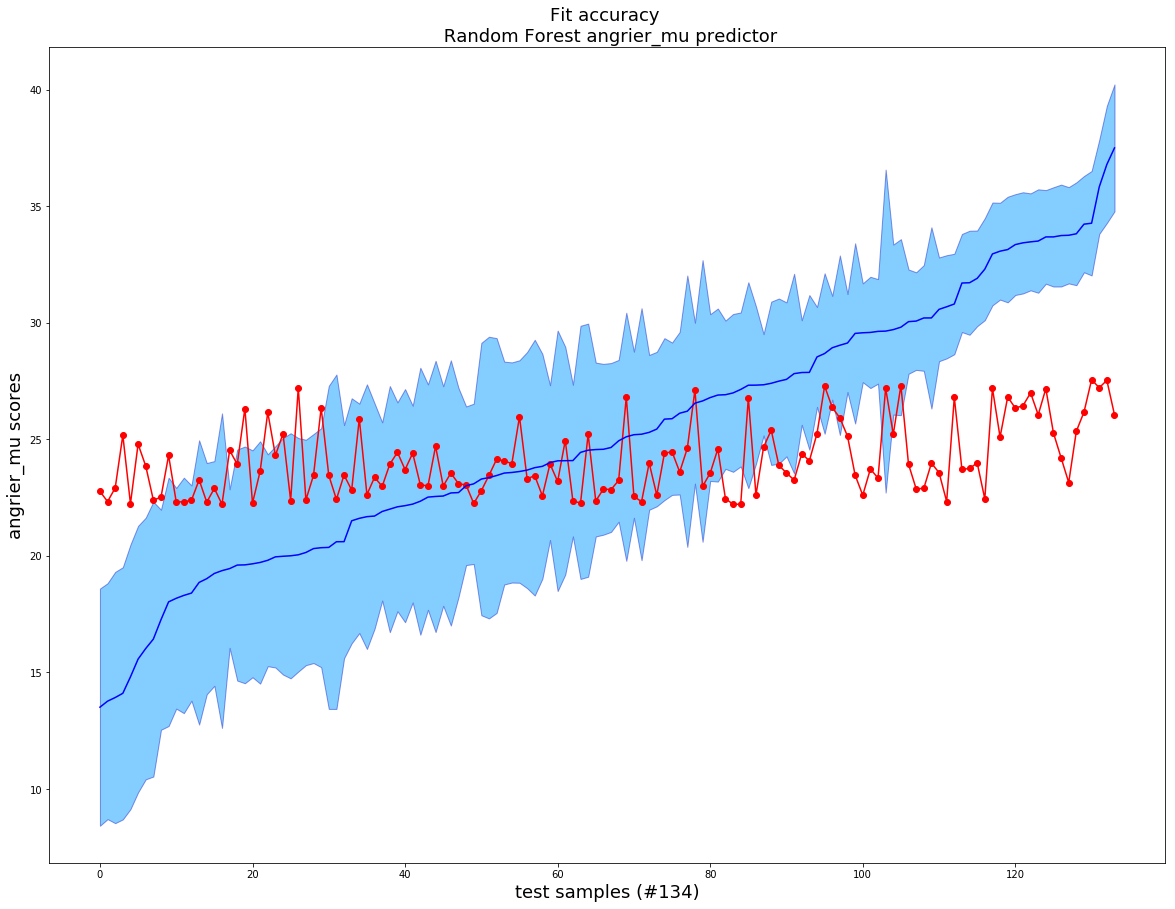

In [42]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testregr_sorted[LABEL].values-y_all_testregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testregr_sorted[LABEL].values+y_all_testregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Random Forest ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

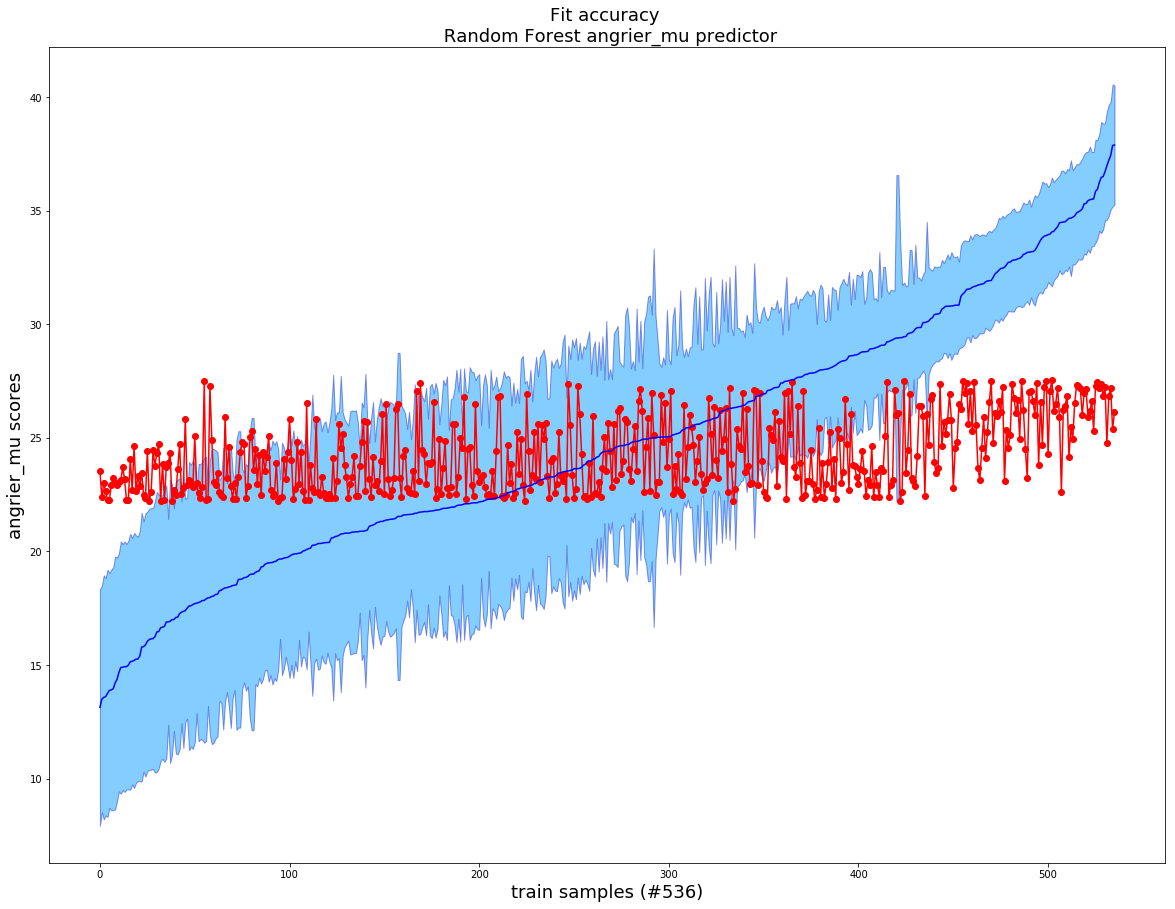

In [43]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainregr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainregr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainregr_sorted[LABEL].values-y_all_trainregr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainregr_sorted[LABEL].values+y_all_trainregr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainregr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Random Forest ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [44]:
# %pylab inline
# pylab.rcParams['figure.figsize'] = (20, 15)
# ax =plt.figure()
# x = np.arange(0, y_all_testregr_randcv_sorted[predicted_name].size, 1)
# plt.errorbar(x,y_all_testregr_randcv_sorted[predicted_name].values,fmt='r-o',label="predicted")
# plt.fill_between(x, y_all_testregr_randcv_sorted[LABEL].values-y_all_testregr_randcv_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testregr_randcv_sorted[LABEL].values+y_all_testregr_randcv_sorted[EMOCONFIDENCE_INV[emotionid]],
#     alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
# plt.errorbar(x,y_all_testregr_randcv_sorted[LABEL].values,fmt='b',label="groundtruth")
# #plt.title(model_dir_name,fontsize=18)
# plt.title('Fit accuracy \n Random Forest w randomized CV\n' + LABEL + ' predictor',fontsize=18)
# plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
# plt.ylabel(LABEL +' scores',fontsize=18)
# plt.show()
# # fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# # ax.savefig(fig_name) 

In [45]:
# pylab.rcParams['figure.figsize'] = (20, 15)
# ax =plt.figure()
# x = np.arange(0, y_all_trainregr_randcv_sorted[predicted_name].size, 1)
# plt.errorbar(x,y_all_trainregr_randcv_sorted[predicted_name].values,fmt='r-o',label="predicted")
# plt.fill_between(x, y_all_trainregr_randcv_sorted[LABEL].values-y_all_trainregr_randcv_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainregr_randcv_sorted[LABEL].values+y_all_trainregr_randcv_sorted[EMOCONFIDENCE_INV[emotionid]],
#     alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
# plt.errorbar(x,y_all_trainregr_randcv_sorted[LABEL].values,fmt='b',label="groundtruth")
# #plt.title(model_dir_name,fontsize=18)
# plt.title('Fit accuracy \n Random Forest w randomized CV\n' + LABEL + ' predictor',fontsize=18)
# plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
# plt.ylabel(LABEL +' scores',fontsize=18)
# plt.show()
# # fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# # ax.savefig(fig_name) 

In [46]:
y_hat_lr = pd.DataFrame(ytest_pred_lr, columns=[predicted_name], index=y_test[LABEL].index) 

y_all_testlr = pd.concat([y_hat_lr, y_test[LABEL], y_test[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_testlr_sorted = y_all_testlr.sort_values(EMOSCORES[emotionid],ascending=[True])

ytrain_hat_lr = pd.DataFrame(ytrain_pred_lr, columns=[predicted_name], index=y_train[LABEL].index) 

y_all_trainlr = pd.concat([ytrain_hat_lr, y_train[LABEL], y_train[EMOCONFIDENCE_INV[emotionid]]], axis=1)

y_all_trainlr_sorted = y_all_trainlr.sort_values(EMOSCORES[emotionid],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


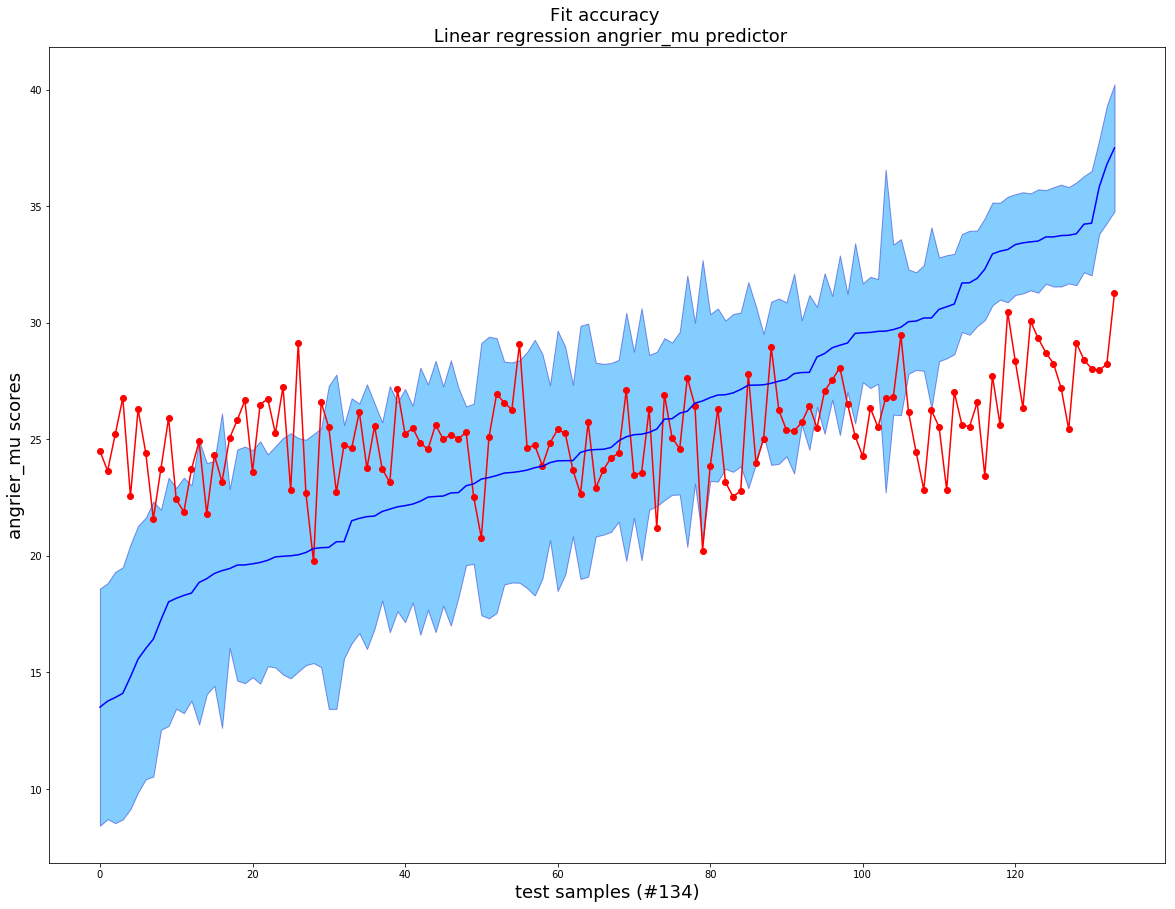

In [47]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testlr_sorted[LABEL].values-y_all_testlr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_testlr_sorted[LABEL].values+y_all_testlr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testlr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

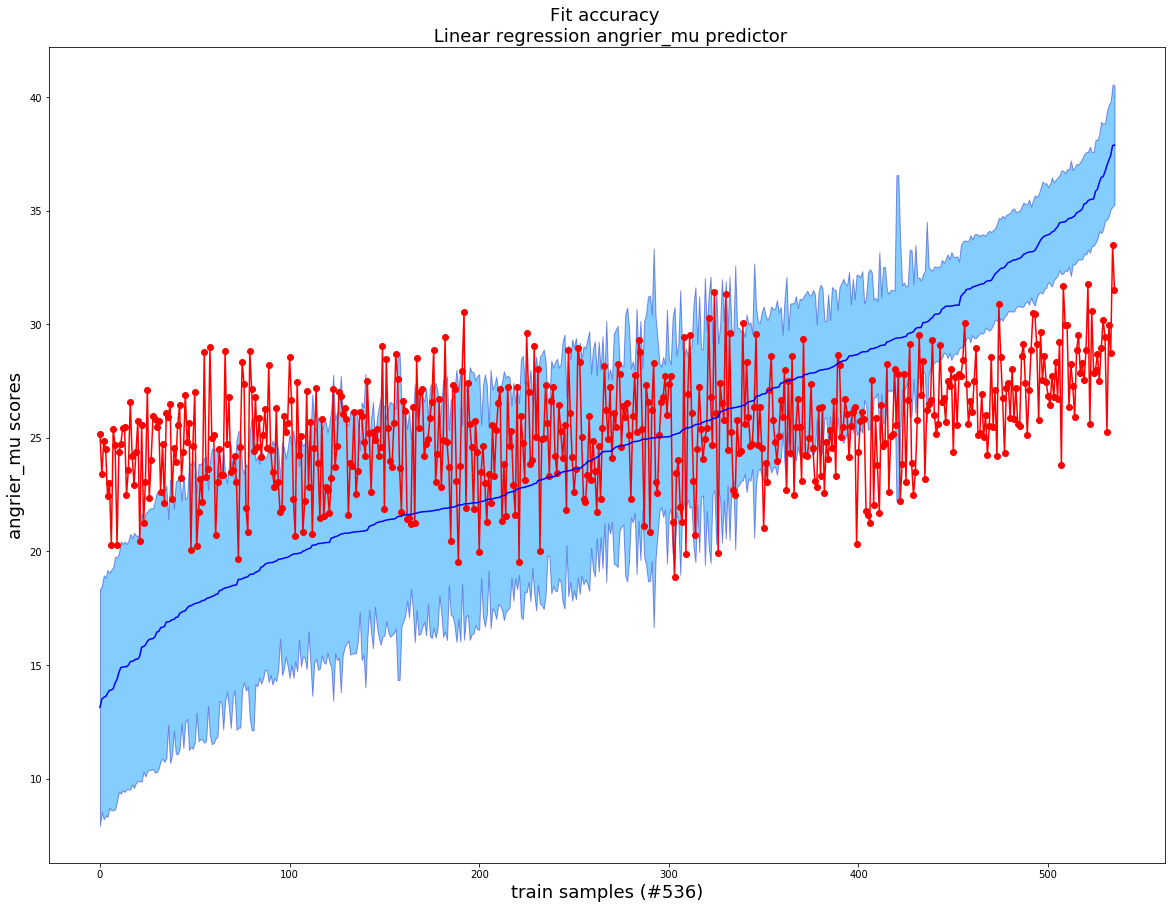

In [48]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_trainlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainlr_sorted[LABEL].values-y_all_trainlr_sorted[EMOCONFIDENCE_INV[emotionid]], y_all_trainlr_sorted[LABEL].values+y_all_trainlr_sorted[EMOCONFIDENCE_INV[emotionid]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainlr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 

In [49]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.5,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.5, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

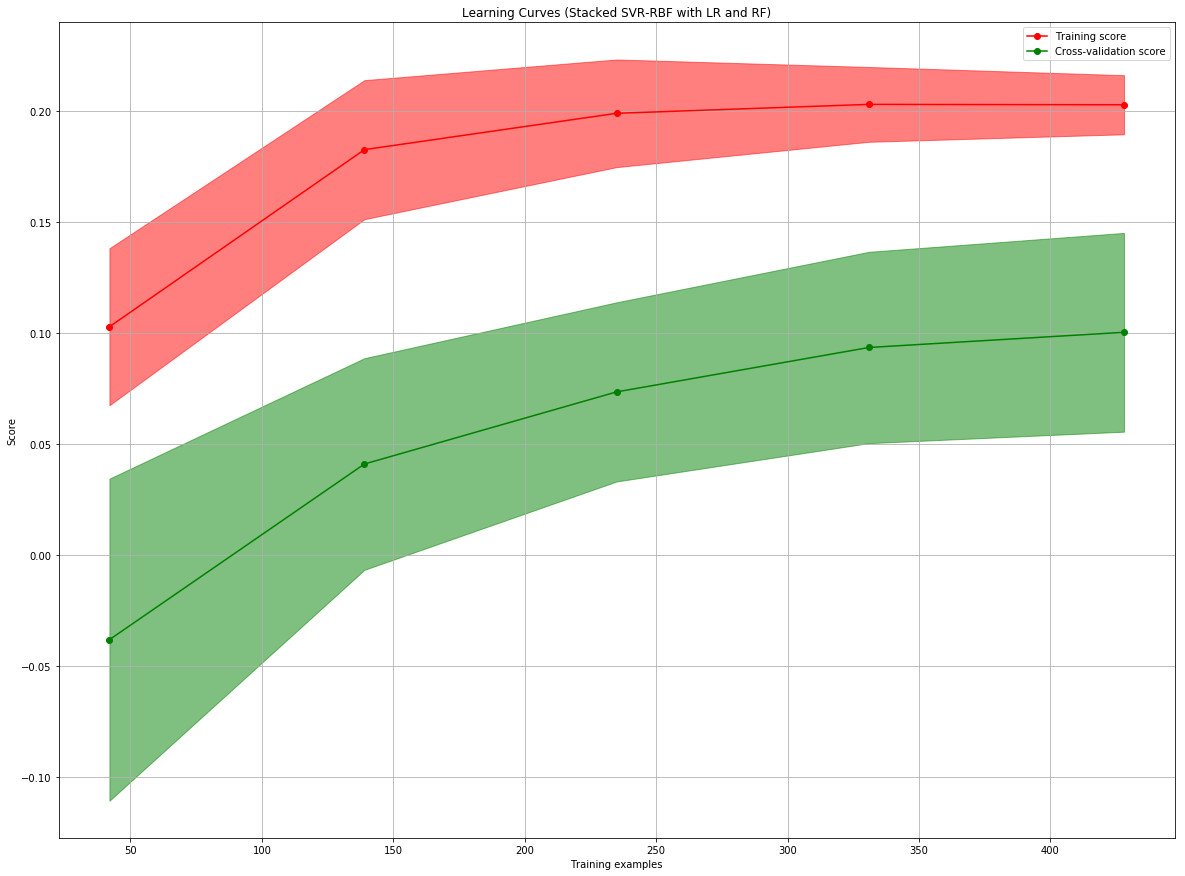

In [50]:
title = "Learning Curves (Stacked SVR-RBF with LR and RF)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

plot_learning_curve(grid_search.best_estimator_, title, X_train, y_train[EMOSCORES[emotionid]],  cv=cv, n_jobs=-1)

plt.show()